PyTorch神经网络建模：
- 数据准备
- 模型建立
- 模型训练
- 模型评估使用和保存

三种常见的训练模型代码编写风格：
- 脚本形式训练循环
- 函数形式训练循环
- 类形式训练循环

In [1]:
import torch
from torch import nn
from torchkeras import summary, Model

import torchvision
from torchvision import transforms

# 数据准备

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="data/minist/", train=True, download=True, transform=transform)
ds_valid = torchvision.datasets.MNIST(root="data/minist/", train=False, download=True, transform=transform)

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=4)
dl_valid =  torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False, num_workers=4)

print(len(ds_train))  # 60000
print(len(ds_valid))  # 10000

60000
10000


# 构建模型

In [3]:
net = nn.Sequential()

net.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3))
net.add_module("pool1", nn.MaxPool2d(kernel_size=2, stride=2))

net.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5))
net.add_module("pool2", nn.MaxPool2d(kernel_size=2, stride=2))

net.add_module("dropout", nn.Dropout2d(p=0.1))
net.add_module("adaptive_pool", nn.AdaptiveMaxPool2d((1, 1)))

net.add_module("flatten", nn.Flatten())
net.add_module("linear1", nn.Linear(64, 32))
net.add_module("relu", nn.ReLU())

net.add_module("linear2", nn.Linear(32, 10))
net.add_module("sigmoid", nn.Sigmoid())

print(net)
summary(net, input_shape=(1, 32, 32))

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]         

# 模型训练设置

定义模型的评估指标，损失函数，优化方法

In [4]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred), dim=1).data
    return accuracy_score(y_true, y_pred_cls)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = accuracy
metric_name = "accuracy"

# 三种风格训练代码

## 脚本式训练风格

In [5]:
epochs = 3
log_step_freq = 100

dfhistory = pd.DataFrame(columns = ["epoch", "loss", metric_name, "val_loss", "val_" + metric_name]) 

print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("%s" % nowtime)

for epoch in range(1, epochs + 1):  

    # 训练循环
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
    
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions, labels)
        metric = metric_func(predictions, labels)
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:   
            print(("[step = %d] loss: %.3f, " + metric_name + ": %.3f") %
                  (step, loss_sum / step, metric_sum / step))
            
    # 验证循环
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features, labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            val_metric = metric_func(predictions, labels)

        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 记录日志
    info = (epoch, loss_sum / step, metric_sum / step, 
            val_loss_sum / val_step, val_metric_sum / val_step)
    dfhistory.loc[epoch - 1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f," + metric_name + \
          "  = %.3f, val_loss = %.3f, " + "val_" + metric_name + " = %.3f") 
          % info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "%s" % nowtime)
        
print('Finished Training...')

Start Training...
2022-02-09 10:20:09
[step = 100] loss: 1.771, accuracy: 0.657
[step = 200] loss: 1.663, accuracy: 0.774
[step = 300] loss: 1.618, accuracy: 0.825
[step = 400] loss: 1.593, accuracy: 0.852

EPOCH = 1, loss = 1.581,accuracy  = 0.866, val_loss = 1.513, val_accuracy = 0.933

2022-02-09 10:20:22
[step = 100] loss: 1.505, accuracy: 0.950
[step = 200] loss: 1.509, accuracy: 0.944
[step = 300] loss: 1.507, accuracy: 0.947
[step = 400] loss: 1.507, accuracy: 0.944

EPOCH = 2, loss = 1.509,accuracy  = 0.942, val_loss = 1.511, val_accuracy = 0.924

2022-02-09 10:20:35
[step = 100] loss: 1.516, accuracy: 0.917
[step = 200] loss: 1.516, accuracy: 0.924
[step = 300] loss: 1.515, accuracy: 0.925
[step = 400] loss: 1.516, accuracy: 0.925

EPOCH = 3, loss = 1.514,accuracy  = 0.925, val_loss = 1.496, val_accuracy = 0.954

2022-02-09 10:20:48
Finished Training...


## 函数风格

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout2d(p=0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1, 1))
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        
        self.linear2 = nn.Linear(32, 10)
        
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.01)
        self.metric_func = accuracy
        self.metric_name = "accuracy"
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        
        y = self.linear2(x)
        
        return y

In [7]:
def train_step(model, features, labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(), metric.item()


@torch.no_grad()
def valid_step(model, features, labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)
    
    return loss.item(), metric.item()


model = Net()
# 测试train_step效果
features, labels = next(iter(dl_train))
train_step(model, features, labels)

(2.27925443649292, 0.1328125)

In [8]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch", "loss", metric_name, "val_loss", "val_" + metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("%s" % nowtime)

    for epoch in range(1, epochs + 1):  

        # 训练循环
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features, labels) in enumerate(dl_train, 1):

            loss, metric = train_step(model, features, labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step % log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, " + metric_name + ": %.3f") %
                      (step, loss_sum / step, metric_sum / step))

        # 验证循环
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features, labels) in enumerate(dl_valid, 1):

            val_loss, val_metric = valid_step(model, features, labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 记录日志
        info = (epoch, loss_sum / step, metric_sum / step, 
                val_loss_sum / val_step, val_metric_sum / val_step)
        dfhistory.loc[epoch - 1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f," + metric_name + \
              "  = %.3f, val_loss = %.3f, " + "val_" + metric_name + " = %.3f") 
              % info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n" + "%s" % nowtime)

    print('Finished Training...')
    return dfhistory

epochs = 3
dfhistory = train_model(model, epochs, dl_train, dl_valid, log_step_freq = 100)

Start Training...
2022-02-09 10:20:49
[step = 100] loss: 0.734, accuracy: 0.757
[step = 200] loss: 0.469, accuracy: 0.846
[step = 300] loss: 0.365, accuracy: 0.882
[step = 400] loss: 0.306, accuracy: 0.901

EPOCH = 1, loss = 0.281,accuracy  = 0.910, val_loss = 0.090, val_accuracy = 0.969

2022-02-09 10:21:02
[step = 100] loss: 0.112, accuracy: 0.966
[step = 200] loss: 0.110, accuracy: 0.967
[step = 300] loss: 0.120, accuracy: 0.964
[step = 400] loss: 0.119, accuracy: 0.964

EPOCH = 2, loss = 0.118,accuracy  = 0.965, val_loss = 0.067, val_accuracy = 0.980

2022-02-09 10:21:14
[step = 100] loss: 0.095, accuracy: 0.970
[step = 200] loss: 0.093, accuracy: 0.971
[step = 300] loss: 0.092, accuracy: 0.972
[step = 400] loss: 0.095, accuracy: 0.971

EPOCH = 3, loss = 0.095,accuracy  = 0.971, val_loss = 0.073, val_accuracy = 0.978

2022-02-09 10:21:26
Finished Training...


## 类风格

使用torchkeras定义的模型接口构建模型，并调用compile方法和fit方法训练模型。

推荐使用该方式

In [9]:
import torchkeras

class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout2d(p=0.1),
            nn.AdaptiveMaxPool2d((1, 1)),
            
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10)]
        )
        
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    
model = torchkeras.Model(CnnModel())    # 封装成了keras里面模型的格式
print(model)

model.summary(input_shape=(1, 32, 32))

Model(
  (net): CnnModel(
    (layers): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): AdaptiveMaxPool2d(output_size=(1, 1))
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=64, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5,

In [10]:
# keras风格
model.compile(loss_func = nn.CrossEntropyLoss(),
             optimizer= torch.optim.Adam(model.parameters(), lr=0.02),
             metrics_dict={"accuracy": accuracy})
          
# 训练只需要一句话
dfhistory = model.fit(3, dl_train=dl_train, dl_val=dl_valid, log_step_freq=100) 

Start Training ...

================================================================================2022-02-09 10:21:27
{'step': 100, 'loss': 1.128, 'accuracy': 0.598}
{'step': 200, 'loss': 0.702, 'accuracy': 0.756}
{'step': 300, 'loss': 0.547, 'accuracy': 0.814}
{'step': 400, 'loss': 0.464, 'accuracy': 0.845}

 +-------+------+----------+----------+--------------+
| epoch | loss | accuracy | val_loss | val_accuracy |
+-------+------+----------+----------+--------------+
|   1   | 0.42 |   0.86   |  0.097   |    0.972     |
+-------+------+----------+----------+--------------+

================================================================================2022-02-09 10:21:39
{'step': 100, 'loss': 0.159, 'accuracy': 0.953}
{'step': 200, 'loss': 0.17, 'accuracy': 0.95}
{'step': 300, 'loss': 0.167, 'accuracy': 0.951}
{'step': 400, 'loss': 0.163, 'accuracy': 0.953}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+----

# 模型评估

评估在训练集和验证集上的效果，模型训练过程中，都是保留着一个dfhistory的，这个是DataFrame结构，里面是训练过程中训练集和验证集上模型的正确率和损失的变化，可以通过可视化这个来看模型的训练情况。
<img style="float: center;" src="images/8.png" width="70%">

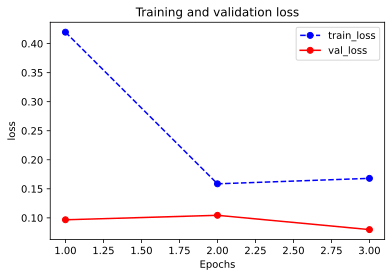

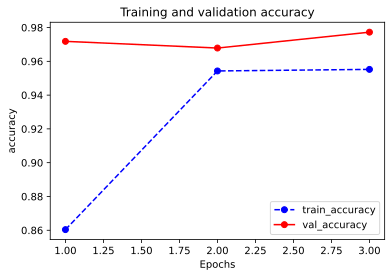

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory, "loss")
plot_metric(dfhistory, "accuracy")

# 模型使用

In [12]:
def predict(model, dl):
    model.eval()
    
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl])
    
    return (result.data)


#预测概率
y_pred_probs = predict(model, dl_valid)

#预测类别
y_pred = torch.where(y_pred_probs > 0.5, torch.ones_like(y_pred_probs),
                     torch.zeros_like(y_pred_probs))

print(y_pred_probs, y_pred)

tensor([[ 11.6875,   8.5880,   5.9874,  ...,  23.5998,   0.9908,  11.9398],
        [  2.3105,   2.0291,  16.4915,  ...,   2.1401,   2.1792,   3.5800],
        [-12.9225,  39.2600, -35.8815,  ...,  -6.6315,  -7.5467, -31.6500],
        ...,
        [ -2.9779,  12.2452, -18.1631,  ...,   7.2492, -30.7973,   7.7018],
        [ -3.0142, -10.9882,   3.0518,  ...,  -6.6530,   6.6556,   0.7834],
        [ 13.8335,  -6.9844,  12.1732,  ..., -30.2260,   3.2087, -11.2383]]) tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 0., 1.,  ..., 0., 1., 1.],
        [1., 0., 1.,  ..., 0., 1., 0.]])


# 模型保存

PyTorch两种保存方式，调用pickle序列化方法实现：
- 只保存模型参数
- 保存整个模型

## 保存模型参数（推荐使用）

In [14]:
print(model.state_dict().keys())

# 保存模型参数

torch.save(model.state_dict(), "net_parameter.pkl")

# # 使用
net_clone = CnnModel()
# net_clone.load_state_dict(torch.load("net_parameter.pkl"))

# 如果报错，模型参数前面有模型名称，则需要做如下处理
checkpoint = torch.load("net_parameter.pkl", map_location=torch.device('cpu'))
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    name = k.replace("net.", "")  # 移除net
    new_state_dict[name] = v

net_clone.load_state_dict(new_state_dict, strict=False)

odict_keys(['net.layers.0.weight', 'net.layers.0.bias', 'net.layers.2.weight', 'net.layers.2.bias', 'net.layers.7.weight', 'net.layers.7.bias', 'net.layers.9.weight', 'net.layers.9.bias'])


<All keys matched successfully>

## 保存整个模型

In [15]:
torch.save(net, 'net_model.pkl')
net_loaded = torch.load('net_model.pkl')